# Transformée en z inverse

Les packages utilisés :

In [1]:
import sympy as sp
import numpy as np
from scipy.signal import lfilter
import matplotlib.pyplot as plt
from IPython.display import display, Math

## Calcul symbolique avec sympy

On considère un exemple $H(z)$ de transformée en $z$, avec les pôles sous forme littérale.

In [2]:
zm1, n = sp.symbols('z^{-1}, n')
P = sp.IndexedBase('P')
Num = 5-7*zm1+2.4*zm1**2
Pn = [(P[1], -0.9), (P[2], 0.9)]
OPn = [3, 4]

Les applications numériques pourront être effectuées via la méthode **subs**.

In [3]:
H = Num
for k in range(len(Pn)):
    H = H/(1 - Pn[k][0]*zm1)**OPn[k]
display(Math('H(z)='+sp.latex(H)))
display(Math('H(z)='+sp.latex(H.subs(Pn))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

La décomposition en élément simple avec la méthode **apart**, après application numérique, ne fonctionne pas pour l'exemple considéré !

In [4]:
display(H.subs(Pn).apart())

2.88065843621399*(0.342857142857143*z^{-1}**2 - 1.0*z^{-1} + 0.714285714285714)/(0.19683*z^{-1}**7 - 0.2187*z^{-1}**6 - 0.729*z^{-1}**5 + 0.81*z^{-1}**4 + 0.9*z^{-1}**3 - 1.0*z^{-1}**2 - 0.37037037037037*z^{-1} + 0.411522633744856)

Il faut donc effectuer la décomposition avec la forme littérale, puis réaliser l'application numérique a posteriori.

In [5]:
def tzinv(Num, Pn, OPn, zm1, n):
    def exprn(ordre, n):
        expr_n = 1
        for k in range(1, ordre):
            expr_n = expr_n*(n+k)
        expr_n = expr_n/sp.factorial(ordre-1)
        return expr_n
    A = sp.IndexedBase('A')
    y = sp.symbols('y')
    An, h, tz = [], 0, 0
    polyP = Num
    for k in range(len(Pn)):
        polyB = sp.Poly(1, zm1)
        for m in range(len(Pn)):
            if m != k:
                polyB = polyB*(1 - Pn[m][1]*zm1)**OPn[m]
        polyB = sp.Poly(polyB.subs(zm1, (1-y)/Pn[k][1]), y)
        polyR = sp.Poly(polyP.subs(zm1, (1-y)/Pn[k][1]), y)
        polyQ = sp.Poly(0, y)
        for m in range(OPn[k]):
            q = polyR.coeff_monomial(y**m)/polyB.coeff_monomial(y**0)
            polyQ = sp.Poly(polyQ+q*y**m, y)
            polyR = sp.Poly(polyR-q*polyB*y**m, y)
        display(Math(sp.latex(Pn[k][0]) + '=' +
                f'{Pn[k][1]}'+'\\quad\\text{ordre}='+f'{OPn[k]}'))
        display(Math('R(y)='+sp.latex(polyR.as_expr().n(4))))
        display(Math('Q(y)='+sp.latex(polyQ.as_expr().n(4))))
        for d in range(OPn[k]):
            An.append((A[Pn[k][0].indices[0], OPn[k]-d],
                      polyQ.coeff_monomial(y**d)))
            tz = tz + A[Pn[k][0].indices[0], OPn[k]-d] / \
                (1-zm1*Pn[k][0])**(OPn[k]-d)
            h = h + exprn(OPn[k]-d, n) * \
                A[Pn[k][0].indices[0], OPn[k]-d]*(Pn[k][0]**n)
    return An, h, tz

In [6]:
An, h, tz = tzinv(Num, Pn, OPn, zm1, n)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [7]:
display(An)
display(Pn)
display(Math('h(n)='+sp.latex(h)))
display(Math('H(z)='+sp.latex(tz)))

[(A[1, 3], 0.983796296296296),
 (A[1, 2], 1.11111111111111),
 (A[1, 1], 0.931712962962962),
 (A[2, 4], 0.0231481481481481),
 (A[2, 3], 0.266203703703704),
 (A[2, 2], 0.752314814814815),
 (A[2, 1], 0.931712962962963)]

[(P[1], -0.9), (P[2], 0.9)]

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Les coefficients des polynômes en $z^{-1}$ du numérateur $N(z)$ et du dénominateur $D(z)$ sont récupérés sous forme numérique selon les puissances croissantes de $z^{-1}$.

In [8]:
Den = sp.fraction(H)[1].subs(Pn)
coeffN = np.array([sp.Poly(Num, zm1).coeff_monomial(zm1**k)
                  for k in range(sp.degree(Num)+1)], dtype=complex).real
coeffD = np.array([sp.Poly(Den, zm1).coeff_monomial(zm1**k)
                  for k in range(sum(OPn)+1)], dtype=complex).real
display(Math('N(z)='+sp.latex(sp.Poly(Num, zm1).as_expr())))
print('coeffN = ', coeffN)
display(Math('D(z)='+sp.latex(sp.Poly(Den, zm1).as_expr())))
print('coeffD = ', coeffD)

<IPython.core.display.Math object>

coeffN =  [ 5.  -7.   2.4]


<IPython.core.display.Math object>

coeffD =  [ 1.        -0.9       -2.43       2.187      1.9683    -1.77147
 -0.531441   0.4782969]


## Calcul numérique avec la fonction **lfilter** de scipy

Les coefficients des polynômes en $z^{-1}$ du numérateur et du dénominateur sont cette fois récupérés selon les puissances croissantes de $z^{-1}$. Il n'est pas nécessaire de réaliser la décomposition en éléments simples et il suffit d'envoyer en entrée une impulsion numérique $\delta(n)$.

In [9]:
N = 50
delta = np.zeros(N+1)
tn = np.arange(N+1)
delta[0] = 1

In [10]:
h_scipy = lfilter(coeffN, coeffD, delta)

## Calcul numérique avec les résultats obtenus avec sympy

L'application numérique s'effectue à partir de l'expression littérale de $h(n)$.

In [11]:
display(h)
h_sympy = np.real(sp.lambdify(n, h.subs(Pn).subs(An), 'numpy')(tn))

(n + 1)*(n + 2)*(n + 3)*A[2, 4]*P[2]**n/6 + (n + 1)*(n + 2)*A[1, 3]*P[1]**n/2 + (n + 1)*(n + 2)*A[2, 3]*P[2]**n/2 + (n + 1)*A[1, 2]*P[1]**n + (n + 1)*A[2, 2]*P[2]**n + A[1, 1]*P[1]**n + A[2, 1]*P[2]**n

## Bilan

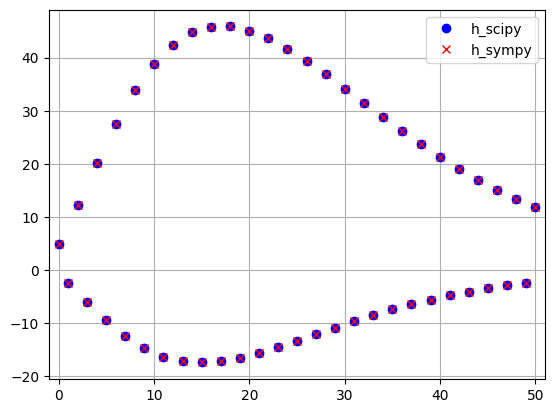

In [12]:
plt.plot(tn, h_scipy, 'bo', label='h_scipy')
plt.plot(tn, h_sympy, 'rx', label='h_sympy')
plt.grid('on')
plt.xlim([-1, N+1])
plt.legend()
plt.show()

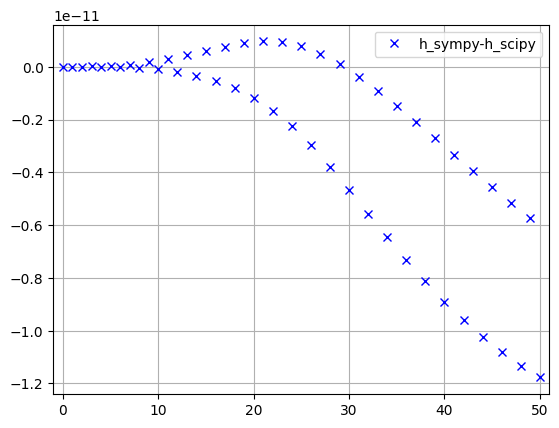

In [13]:
plt.plot(tn, h_sympy-h_scipy, 'bx', label='h_sympy-h_scipy')
plt.grid('on')
plt.xlim([-1, N+1])
plt.legend()
plt.show()